# Constrained Active Learning - Experiment on the XOR problem

#### Importing libraries

In [1]:
#%matplotlib inline
#%autosave 10
import os
import random

import tqdm
import matplotlib.animation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

plt.rc('animation', html='jshtml')

SUPERVISED = "supervised"
RANDOM = "random"
CAL = "constrained"
UNCERTAIN = "uncertainty"

dataset = "xor"
model_folder = os.path.join("models", dataset)
result_folder = os.path.join("results", dataset)
image_folder = os.path.join("images", dataset)
if not os.path.isdir(model_folder):
	os.makedirs(model_folder)
if not os.path.isdir(result_folder):
	os.makedirs(result_folder)
if not os.path.isdir(image_folder):
	os.makedirs(image_folder)
np.random.seed(0)
torch.manual_seed(0)
random.seed(0)
sns.set_theme(style="whitegrid", font="Times New Roman")

#### Generating data for the xor problem

In [2]:
tot_points = 10000
first_points = 10
n_points = 5
n_iterations = 198
seeds = range(5)
x = np.random.uniform(size=(tot_points, 2))
y = np.ndarray.astype(((x[:, 0] > 0.5) & (x[:, 1] < 0.5)) |
                      ((x[:, 1] > 0.5) & (x[:, 0] < 0.5)), float)
pos_idx = np.where(y > 0.5)
neg_idx = np.where(y < 0.5)

#### Visualizing xor data

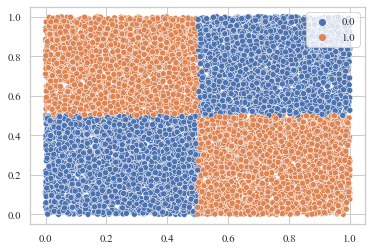

In [3]:
sns.scatterplot(x=x[:, 0], y=x[:, 1], hue=y)
plt.show()


#### Defining constraints as product t-norm of the FOL rule expressing the XOR

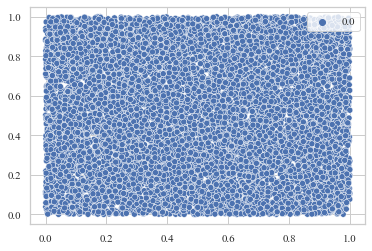

In [4]:
# (x1 & ~x2) | (x2 & ~x1) <=> f
# => f -> (x1 & ~x2) | (~x1 & x2)
# => ~f | ((x1 & ~x2) | (~x1 & x2))                            (converting everything into conjunctions)
# => ~f | (term1 | term2)                                      (each term in CNF is considered a term)
# => ~f | ~((~term1) & (~term2))
# => ~((~(~f)) & ~(~(~term1) & (~term2)))
# => ~(f & ((~term1) & (~term2)))                              (simplifying)
# => 1 - (f * ((1 - term1) * (1 - term2))                      (converting into product T-norm
# => (f * ((1 - (x1 * (1 - x2))) * (1 - (x2 * (1 - x1))))      (converting into loss)
#
# (x1 & ~x2) | (~x1 & x2) -> f
# => ~ ((x1 & ~x2) | (~x1 & x2)) | f                           (each term in CNF is considered a term)
# => ~ (term1 | term2) | f                                     (converting everything into conjunctions)
# => (~(~((~ term1) and (~ term2))) | f                        (not term1 and not term2) = terms
# => (~(~(terms)) | f
# => terms | f
# => ~(~ terms and ~ f)                                        (simplifying)
# => 1 - ((1 - terms) * (1 - f))                               (converting into product t-norm)
# => (1 - terms)) * (1 - f)                                    (converting into loss formulation (1 - formula))
# => (1 - ((1 - term1) * (1 - term2)) * (1 - f)                (replacing again terms with (1 - term1) * (1 - term2)
# => 1 - ((1 - (x1 * (1 - x2)) * (1 - (x2 * (1 - x1)) * (1 - f)

def calculate_constraint_loss(x_continue: torch.Tensor, f: torch.Tensor) -> torch.Tensor:
    discrete_x = (x_continue > 0.5).float()
    x1 = discrete_x[:, 0]
    x2 = discrete_x[:, 1]
    cons_loss1 = f * ((1 - (x1 * (1 - x2))) * (1 - (x2 * (1 - x1))))
    cons_loss2 = (1 - ((1 - (x1 * (1 - x2))) * (1 - (x2 * (1 - x1))))) * (1 - f)
    return cons_loss1 + cons_loss2


x_t = torch.as_tensor(x, dtype=torch.float)
y_t = torch.as_tensor(y, dtype=torch.float)
cons_loss = calculate_constraint_loss(x_t, y_t)
sns.scatterplot(x=x[:, 0], y=x[:, 1], hue=cons_loss)
plt.show()


#### Creating a simple MLP

In [5]:
class MLP(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, 1)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, input_x: torch.Tensor):
        hidden = self.fc1(input_x)
        relu = self.relu(hidden)
        output = self.fc2(relu)
        output = self.sigmoid(output)
        return output


#### Checking outputs before training

In [6]:
def visualize_data_predictions(network: MLP, data: torch.Tensor, labels: torch.Tensor,
                               idx: list = None) -> torch.Tensor:
    x0, x1 = data[:, 0].numpy(), data[:, 1].numpy()
    with torch.no_grad():
        p_t = network(data).squeeze()
    p = p_t.numpy()
    c_loss = calculate_constraint_loss(data, p_t)
    s_loss = torch.nn.BCELoss(reduction="none")(p_t, labels)
    if idx is None:
        idx = [*range(data.shape[0])]
    idx = np.asarray(idx)
    sns.scatterplot(x=x0[idx], y=x1[idx], hue=labels[idx].numpy())
    plt.title("Selected data points")
    plt.xlim([0, 1]), plt.ylim([0, 1]), plt.show()
    sns.scatterplot(x=x0, y=x1, hue=p)
    plt.title("Predictions of the network")
    plt.xlim([0, 1]), plt.ylim([0, 1]), plt.show()
    sns.scatterplot(x=x0, y=x1, hue=c_loss)
    plt.title("Constraint Loss")
    plt.xlim([0, 1]), plt.ylim([0, 1]), plt.show()
    sns.scatterplot(x=x0, y=x1, hue=s_loss)
    plt.title("Supervision Loss")
    plt.xlim([0, 1]), plt.ylim([0, 1]), plt.show()
    acc = (p_t > 0.5).eq(labels).sum().item() / labels.shape[0] * 100
    print(f"Accuracy: {acc}, Sup loss: {s_loss.mean().item()}")
    return acc

#### Few epochs with n randomly selected data

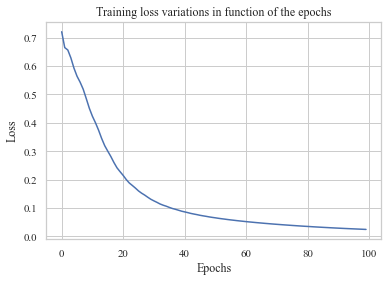

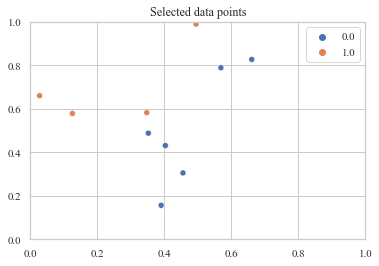

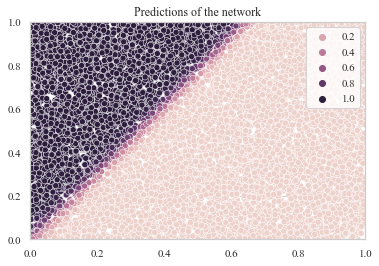

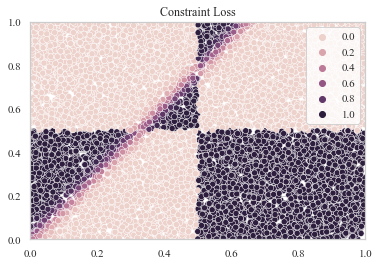

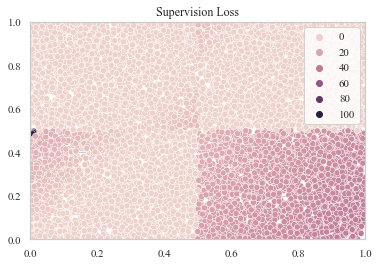

Accuracy: 62.03999999999999, Sup loss: 7.659534931182861


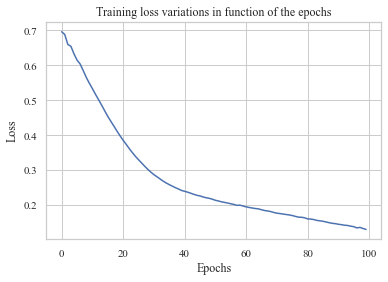

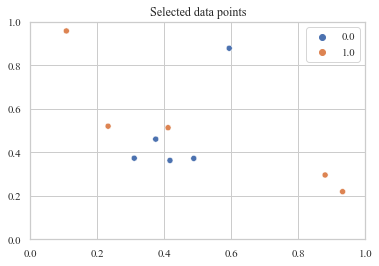

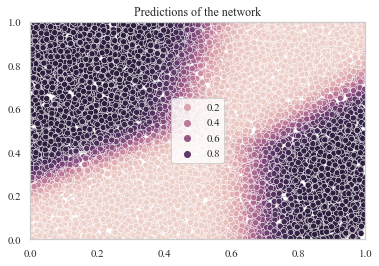

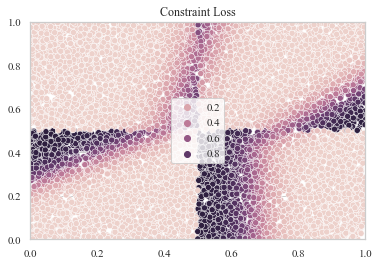

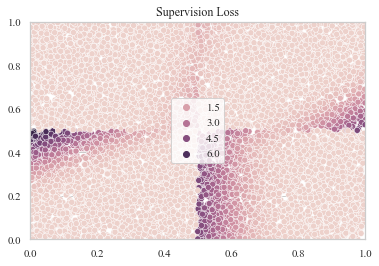

Accuracy: 81.39, Sup loss: 0.5038554668426514


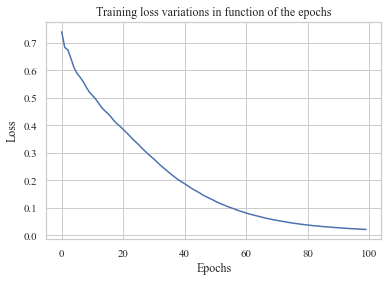

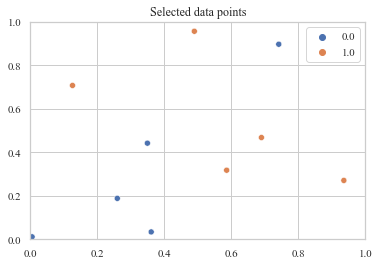

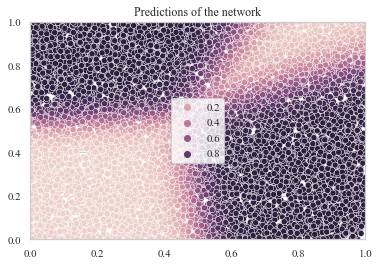

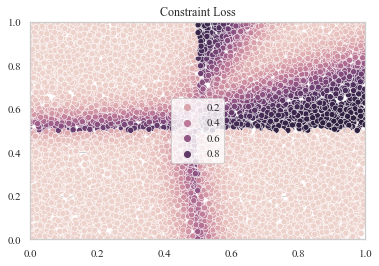

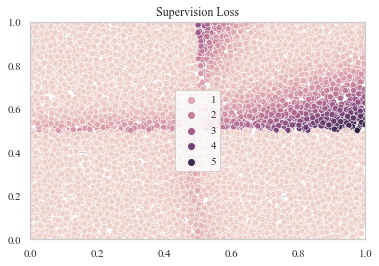

Accuracy: 83.26, Sup loss: 0.39079800248146057


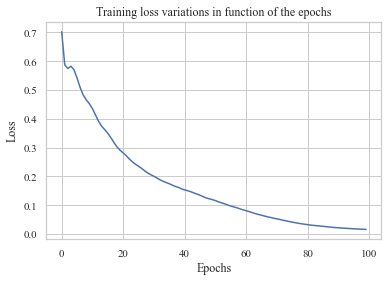

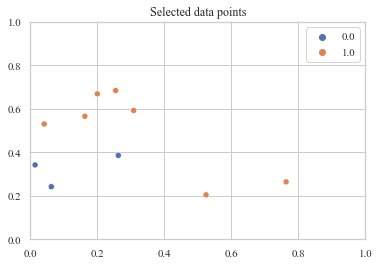

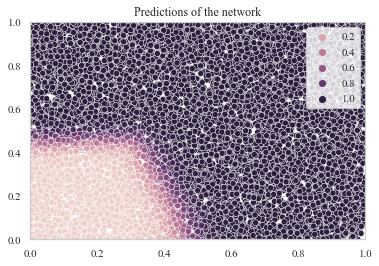

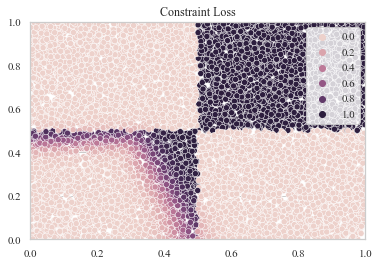

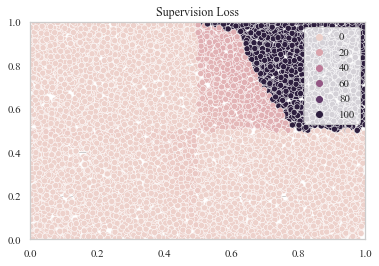

Accuracy: 68.78, Sup loss: 16.97465705871582


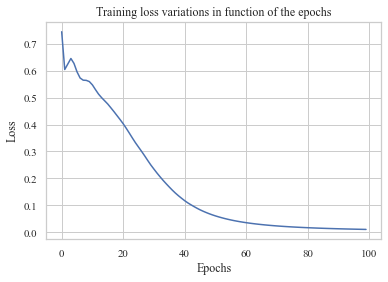

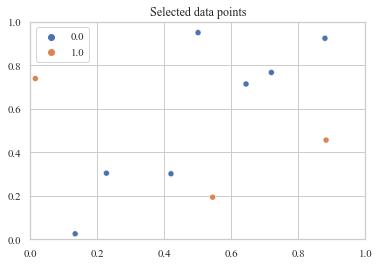

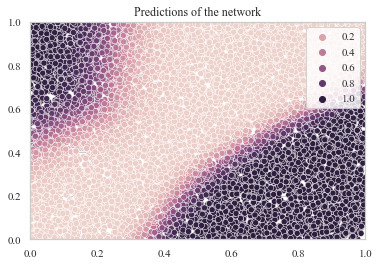

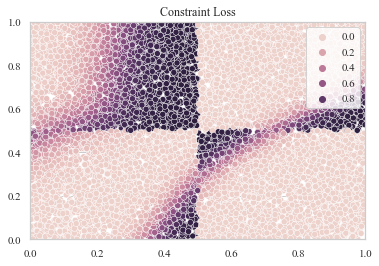

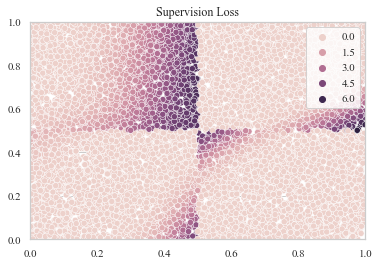

Accuracy: 78.48, Sup loss: 0.6387130618095398


In [7]:
def train_loop(network: MLP, train_data: torch.Tensor, train_labels: torch.Tensor,
               train_idx: list, epochs: int = 100, visualize_loss: bool = False):
    train_idx = np.asarray(train_idx)
    train_data = train_data[train_idx, :]
    train_labels = train_labels[train_idx].squeeze()
    optim = torch.optim.AdamW(network.parameters(), lr=3e-2)
    loss = torch.nn.BCELoss(reduction="none")
    l_train = []
    for j in range(epochs):
        optim.zero_grad()
        p_t = network(train_data).squeeze()
        s_l = loss(p_t, train_labels)
        # s_l[s_l > 1] = 1  # may allow to avoid numerical problems
        s_l = s_l.mean()
        s_l.backward()
        optim.step()
        l_train.append(s_l.item())
    if visualize_loss:
        sns.lineplot(data=l_train)
        plt.ylabel("Loss"), plt.xlabel("Epochs")
        plt.title("Training loss variations in function of the epochs")
        plt.show()
    return l_train


first_idx = []
first_loss = []
first_acc = []
for seed in seeds:
    net = MLP(2, 100)
    first_idx.append([])
    first_idx[seed] += np.random.randint(0, x.shape[0] - 1, first_points).tolist()
    first_loss.append(train_loop(net, x_t, y_t, first_idx[seed], visualize_loss=True))
    first_acc.append(visualize_data_predictions(net, x_t, y_t, first_idx[seed]))
    torch.save(net, f'{model_folder}\\first_train_{seed}.pt')


#### Constrained Active learning strategy
We take n elements which are the one that most violates the constraints and are among available idx

In [8]:
def cal_selection(not_avail_idx: list, c_loss: torch.Tensor, n_p: int) -> list:
    c_loss[torch.as_tensor(not_avail_idx)] = -1
    cal_idx = torch.argsort(c_loss, descending=True).tolist()[:n_p]
    return cal_idx

#### Random Active learning strategy
Theoretically the worst possible strategy.
At each iteration we just take n elements randomly

In [9]:
def random_selection(avail_idx: list, n_p: int) -> list:
    random_idx = np.random.choice(avail_idx, n_p).tolist()
    return random_idx

#### Supervised Active learning strategy
We also consider an upper bound to the learning strategy efficacy.
We directly select the point which mostly violates the supervision loss.

In [10]:
def supervised_selection(not_avail_idx: list, s_loss: torch.Tensor, n_p: int) -> list:
    s_loss[torch.as_tensor(not_avail_idx)] = -1
    sup_idx = torch.argsort(s_loss, descending=True).tolist()[:n_p]
    return sup_idx

#### Uncertainty Active learning strategy
 We take n elements which are the ones most uncertain.

 We define as uncertainty a metric function calculating the proximity to the boundary (predictions = 0.5).
 In order to be a proper metric function we take the opposite of the distance from the boundary mapped into [0,1]

 <em> uncertainty </em> = 1 - 2 * ||preds - 0.5||

In [11]:
def uncertainty_loss(p: torch.Tensor):
    uncertainty = 1 - 2 * torch.abs(p - 0.5)
    return uncertainty


def uncertainty_selection(not_avail_idx: list, u_loss: torch.Tensor, n_p: int) -> list:
    u_loss[torch.as_tensor(not_avail_idx)] = -1
    uncertain_idx = torch.argsort(u_loss, descending=True).tolist()[:n_p]
    return uncertain_idx

#### Active Learning Strategy Comparison

C:\Users\gabri\Anaconda3\envs\fsc\lib\site-packages\ipykernel_launcher.py:49: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


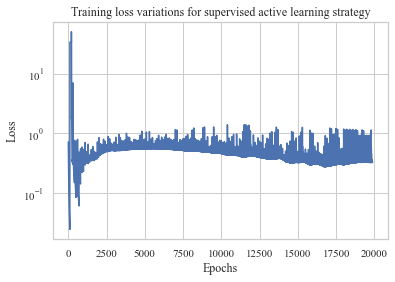

C:\Users\gabri\Anaconda3\envs\fsc\lib\site-packages\ipykernel_launcher.py:49: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


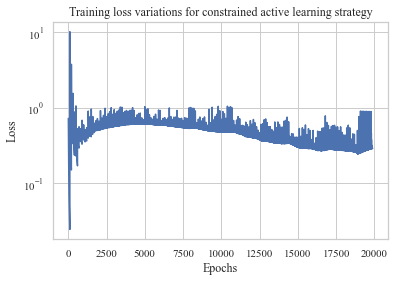

C:\Users\gabri\Anaconda3\envs\fsc\lib\site-packages\ipykernel_launcher.py:49: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


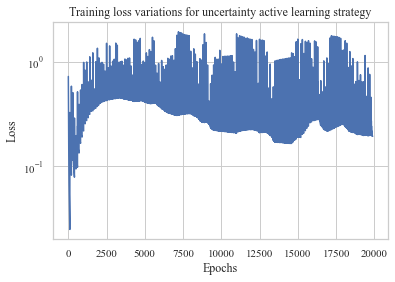

C:\Users\gabri\Anaconda3\envs\fsc\lib\site-packages\ipykernel_launcher.py:49: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


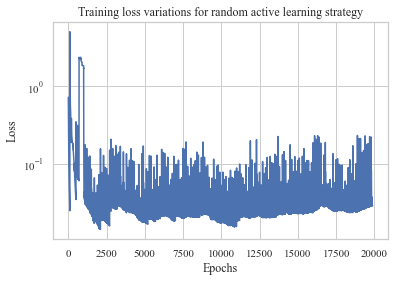

C:\Users\gabri\Anaconda3\envs\fsc\lib\site-packages\ipykernel_launcher.py:49: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [12]:
strategies = [SUPERVISED, CAL, UNCERTAIN, RANDOM]
selection_fun = {
    SUPERVISED: supervised_selection,
    RANDOM: random_selection,
    CAL: cal_selection,
    UNCERTAIN: uncertainty_selection,
}
df = {
    "strategy": [],
    "seed": [],
    "iteration": [],
    "active_idx": [],
    "used_idx": [],
    "predictions": [],
    "accuracy": [],
    "supervision_loss": [],
    "constraint_loss": [],
    "uncertainty_loss": []
}
for seed in seeds:

    for strategy in strategies:
        # Loading weights saved after first training
        net = torch.load(f"{model_folder}\\first_train_{seed}.pt")
        with torch.no_grad():
            preds_t = net(x_t).squeeze()
        accuracy = (preds_t > 0.5).eq(y_t).sum().item() / y_t.shape[0] * 100
        assert first_acc[seed] == accuracy, "Error in loading the network"
        cons_loss = calculate_constraint_loss(x_t, preds_t)
        sup_loss = torch.nn.BCELoss(reduction="none")(preds_t, y_t)
        unc_loss = uncertainty_loss(preds_t)

        active_accuracies = [accuracy]
        available_idx = [*range(tot_points)]
        used_idx: list = first_idx[seed].copy()

        df["strategy"].append(strategy)
        df["seed"].append(seed)
        df["iteration"].append(0)
        df["active_idx"].append(used_idx.copy())
        df["used_idx"].append(used_idx.copy())
        df["predictions"].append(preds_t.numpy())
        df["accuracy"].append(accuracy)
        df["constraint_loss"].append(cons_loss.numpy())
        df["supervision_loss"].append(sup_loss.numpy())
        df["uncertainty_loss"].append(unc_loss.numpy())

        losses = first_loss[seed].copy()
        pbar = tqdm.tqdm_notebook(range(n_iterations))
        for n in range(1, n_iterations + 1):
            available_idx = list(set(available_idx) - set(used_idx))

            if strategy == SUPERVISED:
                active_idx = supervised_selection(used_idx, sup_loss, n_points)
            elif strategy == CAL:
                active_idx = cal_selection(used_idx, cons_loss, n_points)
            elif strategy == UNCERTAIN:
                active_idx = uncertainty_selection(used_idx, unc_loss, n_points)
            else:
                active_idx = random_selection(available_idx, n_points)
            used_idx += active_idx

            losses += train_loop(net, x_t, y_t, used_idx)

            with torch.no_grad():
                preds_t = net(x_t).squeeze()
            accuracy = (preds_t > 0.5).eq(y_t).sum().item() / y_t.shape[0] * 100
            cons_loss = calculate_constraint_loss(x_t, preds_t)
            sup_loss = torch.nn.BCELoss(reduction="none")(preds_t, y_t)
            unc_loss = uncertainty_loss(preds_t)

            df["strategy"].append(strategy)
            df["seed"].append(seed)
            df["iteration"].append(n)
            df["active_idx"].append(active_idx.copy())
            df["used_idx"].append(used_idx.copy())
            df["predictions"].append(preds_t.numpy())
            df["accuracy"].append(accuracy)
            df["constraint_loss"].append(cons_loss.numpy())
            df["supervision_loss"].append(sup_loss.numpy())
            df["uncertainty_loss"].append(unc_loss.numpy())
            pbar.set_description(f"Seed: {seed}/{len(seeds)}, Strategy: {strategy}, {n}/{n_iterations} it, "
                                 f"Acc: {accuracy:.1f}, Sup loss: {sup_loss.mean().item():.2f}, n points: {len(used_idx)}")
            pbar.update()

        pbar.close()
        if seed == 0:
            sns.lineplot(data=losses)
            plt.yscale("log")
            plt.ylabel("Loss")
            plt.xlabel("Epochs")
            plt.title(f"Training loss variations for {strategy} active learning strategy")
            plt.show()

df = pd.DataFrame(df)
df.to_pickle(f"{result_folder}\\metrics_{n_points}_points.pkl")

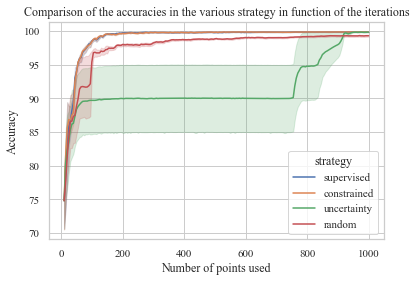

In [13]:
df = pd.read_pickle(f"{result_folder}\\metrics_{n_points}_points.pkl")
df['n_points'] = [len(used) for used in df['used_idx']]
sns.lineplot(data=df, x="n_points", y="accuracy", hue="strategy", ci=75)
plt.ylabel("Accuracy")
plt.xlabel("Number of points used")
plt.title("Comparison of the accuracies in the various strategy in function of the iterations")
plt.savefig(f"{image_folder}\\Accuracy_{n_points}_points.png")
plt.show()


#### Create animation to visualize training

In [14]:
def animate_points_and_prediction(i, active_strategy, dataframe):
    print(i)
    dataframe = dataframe[dataframe["seed"] == 0]
    df_strategy = dataframe[dataframe["strategy"] == active_strategy].reset_index()
    if i != len(df_strategy["active_idx"]):
        a_idx = df_strategy["active_idx"][i]
        u_idx = df_strategy["used_idx"][i]
    else:
        a_idx = []
        u_idx = df_strategy["used_idx"][i-1]
    new_idx = [1 if idx in a_idx else 0 for idx in u_idx]
    x0, x1 = x[:, 0], x[:, 1]
    if i == 0:
        preds = df_strategy["predictions"][i]
    else:
        preds = df_strategy["predictions"][i-1]
    sns.scatterplot(x=x0, y=x1, hue=preds, legend=False)
    sns.scatterplot(x=x0[np.asarray(u_idx)], y=x1[np.asarray(u_idx)],
                    hue=new_idx, legend=False)
    plt.axhline(0.5, 0, 1, c="k")
    plt.axvline(0.5, 0, 1, c="k")
    plt.title(f"Selected data points for {strategy} training, iter {i}")


def animate_cons_loss(i, active_strategy, dataframe):
    df_strategy = dataframe[dataframe["strategy"] == active_strategy].reset_index()
    cons_loss = df_strategy["constraint_loss"][i]
    x0, x1 = x[:, 0], x[:, 1]
    sns.scatterplot(x=x0, y=x1, hue=cons_loss, legend=False)


def animate_sup_loss(i, active_strategy, dataframe):
    df_strategy = dataframe[dataframe["strategy"] == active_strategy].reset_index()
    sup_loss = df_strategy["supervision_loss"][i]
    x0, x1 = x[:, 0], x[:, 1]
    sns.scatterplot(x=x0, y=x1, hue=sup_loss, legend=False)

#### Displaying the animations

In [ ]:
writer = matplotlib.animation.FFMpegWriter(fps=1)
strategy = SUPERVISED
fig = plt.figure()
ani_sup = matplotlib.animation.FuncAnimation(fig, animate_points_and_prediction, interval=1000,
                                         frames=n_iterations+1, fargs=[strategy, df])
ani_sup.save(f"{image_folder}\\{strategy}_point_selection_{n_points}_points.mp4", writer=writer)

0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89


In [ ]:
ani_sup

In [ ]:
strategy = CAL
fig = plt.figure()
ani_cal = matplotlib.animation.FuncAnimation(fig, animate_points_and_prediction, interval=1000,
                                         frames=n_iterations+1, fargs=[strategy, df])
ani_cal.save(f"{image_folder}\\{strategy}_point_selection_{n_points}_points.mp4", writer=writer)

In [ ]:
ani_cal

In [ ]:
strategy = UNCERTAIN
fig = plt.figure()
ani_unc = matplotlib.animation.FuncAnimation(fig, animate_points_and_prediction, interval=1000,
                                         frames=n_iterations+1,  fargs=[strategy, df])
ani_unc.save(f"{image_folder}\\{strategy}_point_selection_{n_points}_points.mp4", writer=writer)


In [ ]:
ani_unc

In [ ]:
writer = matplotlib.animation.FFMpegWriter(fps=1)
strategy = RANDOM
fig = plt.figure()
ani_rand = matplotlib.animation.FuncAnimation(fig, animate_points_and_prediction, interval=1000,
                                         frames=n_iterations+1, repeat=True, fargs=[strategy, df])
ani_rand.save(f"{image_folder}\\{strategy}_point_selection_{n_points}_points.mp4", writer=writer)

In [ ]:
ani_rand